In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer

from paths import RAW_DIR, STAGE_DIR
from display import cdisplay, rdisplay
from transformers import *
from functions import to_numeric, to_binary_from_nan, inspect_nulls

### Import the data

In [3]:
patient_1 = pd.read_excel(RAW_DIR / 'breast_cancer_data.xlsx')
patient_2 = pd.read_excel(RAW_DIR / 'breast_cancer_data_2.xlsx')

# concatenate the two datasets
data = pd.concat([patient_1, patient_2]).drop(['Unnamed: 0'], axis=1)
data.head(20)

,ehr,side,neoadjuvant,grade,invasive,er_positive,pr_positive,her2_positive,ki67,birth_date,diagnosis_date,death_date,recurrence_year,menarche_age,menopause_age,pregnancy,abort,birth,caesarean,hist_type
0,6849,NaN,no,1.0,1.0,1.0,1.0,1.0,NaN,1967-08-08,2016-08-23,NaN,NaN,17.0,51.0,2.0,0.0,2,NaN,ductal
1,268,NaN,no,NaN,1.0,1.0,1.0,0.0,NaN,1950-03-11,2015-09-05,NaN,NaN,12.0,NaN,2.0,0.0,2,NaN,unknown
2,1458,NaN,no,1.0,1.0,1.0,1.0,0.0,0.0,1953-09-17,2017-03-01,NaN,NaN,11.0,NaN,2.0,0.0,2,0.0,ductal
3,268,NaN,no,NaN,1.0,1.0,1.0,0.0,NaN,1950-03-11,2015-09-05,NaN,NaN,12.0,NaN,2.0,0.0,2,NaN,unknown
4,2013,NaN,yes,3.0,1.0,1.0,1.0,1.0,17.0,1977-08-19,2014-08-31,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,ductal
5,1350,NaN,no,2.0,1.0,0.0,1.0,0.0,44.0,1951-04-02,2003-05-24,2022-05-11,NaN,14.0,NaN,3.0,NaN,3,NaN,ductal
6,5850,NaN,no,1.0,1.0,1.0,1.0,0.0,10.0,1958-11-12,2020-09-05,NaN,NaN,15.0,58.0,2.0,0.0,2,NaN,unknown
7,268,NaN,no,NaN,1.0,1.0,1.0,0.0,NaN,1950-03-11,2015-09-05,NaN,NaN,12.0,NaN,2.0,0.0,2,NaN,unknown
8,953,NaN,no,1.0,1.0,1.0,0.0,0.0,10.0,1949-03-19,2021-07-11,NaN,NaN,13.0,NaN,NaN,NaN,-1,NaN,unknown
9,773,NaN,no,2.0,1.0,1.0,1.0,0.0,10.0,1946-04-21,2017-09-26,NaN,NaN,NaN,50.0,2.0,0.0,2,NaN,ductal


### Solving duplicates in `ehr`

In [4]:
data['ehr'].value_counts(dropna=False)

268     3
6897    2
876     1
5537    1
6574    1
       ..
965     1
41      1
4483    1
3005    1
7066    1
Name: ehr, Length: 241, dtype: int64

In [5]:
cdisplay(data[data['ehr'].isin([268, 6897])])

,ehr,side,neoadjuvant,grade,invasive,er_positive,pr_positive,her2_positive,ki67,birth_date,diagnosis_date,death_date,recurrence_year,menarche_age,menopause_age,pregnancy,abort,birth,caesarean,hist_type
1,268,NaN,no,NaN,1.0,1.0,1.0,0.0,NaN,1950-03-11,2015-09-05,NaN,NaN,12.0,NaN,2.0,0.0,2,NaN,unknown
3,268,NaN,no,NaN,1.0,1.0,1.0,0.0,NaN,1950-03-11,2015-09-05,NaN,NaN,12.0,NaN,2.0,0.0,2,NaN,unknown
7,268,NaN,no,NaN,1.0,1.0,1.0,0.0,NaN,1950-03-11,2015-09-05,NaN,NaN,12.0,NaN,2.0,0.0,2,NaN,unknown
82,6897,right,no,NaN,1.0,1.0,1.0,0.0,15.0,1966-09-30,2006-02-15,NaN,2020.0,12.0,42.0,2.0,0.0,2,2.0,ductal
170,6897,right,no,NaN,1.0,1.0,1.0,0.0,15.0,1966-09-30,2006-02-15,NaN,2020.0,12.0,42.0,2.0,0.0,2,2.0,ductal


We can see that repeated observations of patients 268 and 6897 have identical values for the rest of the columns. For this reason, we can drop the repeated observations.

In [6]:
data = data.drop_duplicates()

In [7]:
cdisplay(data)

,ehr,side,neoadjuvant,grade,invasive,er_positive,pr_positive,her2_positive,ki67,birth_date,diagnosis_date,death_date,recurrence_year,menarche_age,menopause_age,pregnancy,abort,birth,caesarean,hist_type
0,6849,NaN,no,1.0,1.0,1.0,1.0,1.0,NaN,1967-08-08,2016-08-23,NaN,NaN,17.0,51.0,2.0,0.0,2,NaN,ductal
1,268,NaN,no,NaN,1.0,1.0,1.0,0.0,NaN,1950-03-11,2015-09-05,NaN,NaN,12.0,NaN,2.0,0.0,2,NaN,unknown
2,1458,NaN,no,1.0,1.0,1.0,1.0,0.0,0.0,1953-09-17,2017-03-01,NaN,NaN,11.0,NaN,2.0,0.0,2,0.0,ductal
4,2013,NaN,yes,3.0,1.0,1.0,1.0,1.0,17.0,1977-08-19,2014-08-31,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,ductal
5,1350,NaN,no,2.0,1.0,0.0,1.0,0.0,44.0,1951-04-02,2003-05-24,2022-05-11,NaN,14.0,NaN,3.0,NaN,3,NaN,ductal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,6647,NaN,yes,NaN,1.0,1.0,1.0,0.0,NaN,1984-01-29,2014-05-22,NaN,NaN,12.0,NaN,NaN,NaN,-1,NaN,ductal
25,768,NaN,no,NaN,NaN,1.0,1.0,0.0,NaN,1953-03-12,1997-10-25,NaN,2010.0,13.0,NaN,0.0,NaN,-1,NaN,unknown
26,4534,NaN,no,NaN,1.0,NaN,NaN,0.0,NaN,1959-06-25,2003-11-10,NaN,NaN,11.0,40.0,2.0,0.0,2,NaN,ductal
27,7062,NaN,no,NaN,1.0,1.0,1.0,0.0,0.0,1971-03-21,2020-11-07,NaN,NaN,16.0,NaN,NaN,NaN,-1,NaN,ductal


### Creating new columns

In [8]:
data[pd.to_datetime(data['diagnosis_date']).gt(dt.datetime.today())]

,ehr,side,neoadjuvant,grade,invasive,er_positive,pr_positive,her2_positive,ki67,birth_date,diagnosis_date,death_date,recurrence_year,menarche_age,menopause_age,pregnancy,abort,birth,caesarean,hist_type
45,4998,NaN,no,1.0,1.0,1.0,1.0,0.0,0.0,1944-11-10,2022-12-31,NaN,2020.0,13.0,52.0,2.0,0.0,2,NaN,unknown


In [9]:
data[pd.to_datetime(data['diagnosis_date']).gt(pd.to_datetime(data['death_date']))]

,ehr,side,neoadjuvant,grade,invasive,er_positive,pr_positive,her2_positive,ki67,birth_date,diagnosis_date,death_date,recurrence_year,menarche_age,menopause_age,pregnancy,abort,birth,caesarean,hist_type
27,6953,NaN,no,NaN,1.0,1.0,1.0,0.0,30.0,1947-11-17,2013-10-07,2013-07-11,2017.0,13.0,50.0,3.0,1.0,2,NaN,ductal
87,965,NaN,yes,2.0,1.0,0.0,1.0,0.0,0.0,1925-03-27,2022-05-01,2021-06-06,NaN,13.0,44.0,3.0,0.0,3,NaN,lobular
151,5161,NaN,yes,NaN,1.0,1.0,1.0,0.0,18.0,1948-09-01,2019-02-25,2013-05-03,NaN,NaN,NaN,2.0,0.0,2,NaN,unknown
14,4560,left,no,2.0,1.0,0.0,1.0,1.0,NaN,1959-10-18,2021-04-17,2011-02-25,NaN,12.0,NaN,2.0,0.0,1,1.0,unknown
28,7066,NaN,yes,2.0,1.0,0.0,0.0,0.0,60.0,1979-03-25,2019-02-19,2017-11-20,2021.0,12.0,NaN,0.0,0.0,0,NaN,ductal


In [10]:
assign_map = {
    # fix diagnosis date
    'diagnosis_date': lambda df: np.select(
        [pd.to_datetime(df['diagnosis_date']).gt(dt.datetime.today()),
         pd.to_datetime(df['diagnosis_date']).gt(pd.to_datetime(df['death_date']))],
        [dt.datetime.today().strftime('%Y-%m-%d'), df['death_date']],
        df['diagnosis_date']
    ),

    'age': lambda df: np.where(
        df['death_date'].isna(),
        dt.datetime.today() - pd.to_datetime(df['birth_date']),
        pd.to_datetime(df['death_date']) - pd.to_datetime(df['birth_date'])
    ).astype('timedelta64[Y]').astype(int),
    'years_from_diagnosis': lambda df: np.where(
        df['death_date'].isna(),
        dt.datetime.today() - pd.to_datetime(df['diagnosis_date']),
        pd.to_datetime(df['death_date']) - pd.to_datetime(df['diagnosis_date'])
    ).astype('timedelta64[Y]').astype(int),
    'is_dead': lambda df: to_binary_from_nan(df, 'death_date'),
    'recurrence': lambda df: to_binary_from_nan(df, 'recurrence_year'),
    'menopause': lambda df: to_binary_from_nan(df, 'menopause_age'),
    # NOTE 1 null value in neoadjuvant: probably is going to be solved when
    # merging with the other dataset
    'neoadjuvant': lambda df: df['neoadjuvant'].replace({'no': 0, 'yes': 1}),
    # NOTE birth = -1 doesn't make sense --> replace it with 0
    'birth': lambda df: np.where(
        df['birth'].eq(-1) & df['pregnancy'].gt(0),
        df['pregnancy'],
        df['birth'].replace({-1: 0})
    ).astype(int),
    'caesarean': lambda df: np.where(
        df[['pregnancy', 'abort', 'birth']].gt(0).all(1) \
            & df['caesarean'].isna()\
            & (df['pregnancy'] - df['abort'] - df['birth']).ge(0),
        df['pregnancy'] - df['abort'] - df['birth'],
        df['caesarean'].fillna(0)
    ).astype(int),
    'abort': lambda df: df['abort'].fillna(0).astype(int),
    'pregnancy': lambda df: np.where(
        df['pregnancy'].isna() \
            | ~df['pregnancy'].eq(df['birth'] + df['caesarean'] + df['abort']),
        df['birth'] + df['caesarean'] + df['abort'],
        df['pregnancy']
    ).astype(int),
    # utils for imputation
    'group_age': lambda df: np.select(
        [df['age'].isin(list(range(i, i + 10))) for i in range(1, 100, 10)],
        [f'{i} - {i + 10}' for i in range(1, 100, 10)],
        '100+'
    ),
    'group_years_from_diagnosis': lambda df: np.select(
        [df['years_from_diagnosis'].isin(list(range(i, i + 5)))
         for i in range(1, 30, 5)],
        [f'{i} - {i + 5}' for i in range(1, 30, 5)],
        '30+'
    ),
}

assign_transformer = AssignTransformer(assign_map)
assigned_data = assign_transformer.transform(data)

In [11]:
assigned_data[['birth', 'abort', 'caesarean', 'pregnancy']].value_counts(dropna=False).sort_index()

birth  abort  caesarean  pregnancy
0      0      0          0            132
              2          2              1
       1      0          1              2
       2      0          2              1
1      0      0          1             19
              1          2              4
       1      0          2              5
              1          3              1
       2      1          4              1
2      0      0          2             34
              2          4              4
       1      0          3             10
       2      0          4              2
       3      0          5              1
3      0      0          3             13
       1      0          4              3
       3      0          6              1
4      0      0          4              2
       1      0          5              3
5      0      0          5              1
6      0      0          6              1
dtype: int64

In [12]:
assigned_data['group_age'].value_counts(dropna=False)

51 - 61     74
61 - 71     52
41 - 51     49
71 - 81     35
81 - 91     15
31 - 41     11
91 - 101     3
100+         2
Name: group_age, dtype: int64

In [13]:
assigned_data['group_years_from_diagnosis'].value_counts(dropna=False)

1 - 6      86
6 - 11     69
11 - 16    34
30+        28
16 - 21    15
21 - 26     7
26 - 31     2
Name: group_years_from_diagnosis, dtype: int64

### Drop columns

In [14]:
inspect_nulls(assigned_data)

side               227
neoadjuvant          1
grade               91
invasive            34
er_positive         24
pr_positive         27
her2_positive       42
ki67                69
death_date         217
recurrence_year    209
menarche_age        53
menopause_age      149
dtype: int64

In [15]:
# drop birth_date, diagnosis_date, side (more than 200 null)
drop_transformer = FunctionTransformer(
    func=lambda df: df.drop([
        'birth_date', 'diagnosis_date', 'death_date', 'recurrence_year',
        'menopause_age', 'side'], axis=1)
)
dropped_data = drop_transformer.transform(assigned_data)
dropped_data.head(20)

,ehr,neoadjuvant,grade,invasive,er_positive,pr_positive,her2_positive,ki67,menarche_age,pregnancy,abort,birth,caesarean,hist_type,age,years_from_diagnosis,is_dead,recurrence,menopause,group_age,group_years_from_diagnosis
0,6849,0.0,1.0,1.0,1.0,1.0,1.0,NaN,17.0,2,0,2,0,ductal,55,6,0,0,1,51 - 61,6 - 11
1,268,0.0,NaN,1.0,1.0,1.0,0.0,NaN,12.0,2,0,2,0,unknown,72,7,0,0,0,71 - 81,6 - 11
2,1458,0.0,1.0,1.0,1.0,1.0,0.0,0.0,11.0,2,0,2,0,ductal,69,5,0,0,0,61 - 71,1 - 6
4,2013,1.0,3.0,1.0,1.0,1.0,1.0,17.0,NaN,0,0,0,0,ductal,45,8,0,0,0,41 - 51,6 - 11
5,1350,0.0,2.0,1.0,0.0,1.0,0.0,44.0,14.0,3,0,3,0,ductal,71,18,1,0,0,71 - 81,16 - 21
6,5850,0.0,1.0,1.0,1.0,1.0,0.0,10.0,15.0,2,0,2,0,unknown,64,2,0,0,1,61 - 71,1 - 6
8,953,0.0,1.0,1.0,1.0,0.0,0.0,10.0,13.0,0,0,0,0,unknown,73,1,0,0,0,71 - 81,1 - 6
9,773,0.0,2.0,1.0,1.0,1.0,0.0,10.0,NaN,2,0,2,0,ductal,76,5,0,0,1,71 - 81,1 - 6
10,2470,0.0,2.0,1.0,1.0,0.0,0.0,0.0,12.0,0,0,0,0,lobular,81,6,0,0,0,81 - 91,6 - 11
11,5380,0.0,1.0,1.0,1.0,1.0,0.0,20.0,14.0,0,0,0,0,unknown,69,10,0,0,1,61 - 71,6 - 11


In [16]:
dropped_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 0 to 28
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ehr                         241 non-null    int64  
 1   neoadjuvant                 240 non-null    float64
 2   grade                       150 non-null    float64
 3   invasive                    207 non-null    float64
 4   er_positive                 217 non-null    float64
 5   pr_positive                 214 non-null    float64
 6   her2_positive               199 non-null    float64
 7   ki67                        172 non-null    float64
 8   menarche_age                188 non-null    float64
 9   pregnancy                   241 non-null    int32  
 10  abort                       241 non-null    int32  
 11  birth                       241 non-null    int32  
 12  caesarean                   241 non-null    int32  
 13  hist_type                   241 non-

### Impute null values

In [32]:
GROUPS_INDEX = ['group_age']
GROUP_MODE_IMPUTE = ['er_positive', 'pr_positive', 'her2_positive', 'grade']
GROUP_MEAN_IMPUTE = ['ki67']
GLOBAL_MODE_IMPUTE = ['menarche_age']

global_imputer = SimpleImputerTransformer(strategy='most_frequent')

group_imputer_map = {
    **{
        variable: lambda df, variable=variable: np.where(
            df[variable].isna(),
            df[GROUPS_INDEX].merge(
                df.groupby(GROUPS_INDEX)[variable].apply(lambda x:
                    x.mode().iloc[0] if not x.mode().empty else np.NaN),
                left_on=GROUPS_INDEX, right_index=True, how='left')[variable],
            df[variable]
        ).astype(int)
        for variable in GROUP_MODE_IMPUTE
    },
    **{
        variable: lambda df, variable=variable: np.where(
            df[variable].isna(),
            df[GROUPS_INDEX].merge(
                df.groupby(GROUPS_INDEX)[variable].apply('mean'),
                left_on=GROUPS_INDEX, right_index=True, how='left')[variable],
            df[variable]
        )
        for variable in GROUP_MEAN_IMPUTE
    },
}
group_imputer = AssignTransformer(group_imputer_map)

imputer_transformer = PandasColumnTransformer([
    ('global_imputer', global_imputer, GLOBAL_MODE_IMPUTE),
    ('group_imputer', group_imputer, GROUPS_INDEX + GROUP_MODE_IMPUTE + GROUP_MEAN_IMPUTE)
], remainder='passthrough')

imputed_data = imputer_transformer.fit_transform(dropped_data)

In [27]:
inspect_nulls(imputed_data)

neoadjuvant     1
invasive       34
dtype: int64

In [33]:
imputed_data[GROUP_MODE_IMPUTE + GROUP_MEAN_IMPUTE + GLOBAL_MODE_IMPUTE]

,er_positive,pr_positive,her2_positive,grade,ki67,menarche_age
0,1,1,1,1,19.058824,17.0
1,1,1,0,2,22.642857,12.0
2,1,1,0,1,0.000000,11.0
4,1,1,1,3,17.000000,13.0
5,0,1,0,2,44.000000,14.0
...,...,...,...,...,...,...
24,1,1,0,2,35.000000,12.0
25,1,1,0,1,24.228571,13.0
26,1,1,0,1,24.228571,11.0
27,1,1,0,2,0.000000,16.0


In [34]:
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 0 to 28
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   menarche_age                241 non-null    float64
 1   group_age                   241 non-null    object 
 2   er_positive                 241 non-null    int32  
 3   pr_positive                 241 non-null    int32  
 4   her2_positive               241 non-null    int32  
 5   grade                       241 non-null    int32  
 6   ki67                        241 non-null    float64
 7   ehr                         241 non-null    int64  
 8   neoadjuvant                 240 non-null    float64
 9   invasive                    207 non-null    float64
 10  pregnancy                   241 non-null    int32  
 11  abort                       241 non-null    int32  
 12  birth                       241 non-null    int32  
 13  caesarean                   241 non-

### Data Visualization

Text(0.5, 1.0, 'Recurrence')

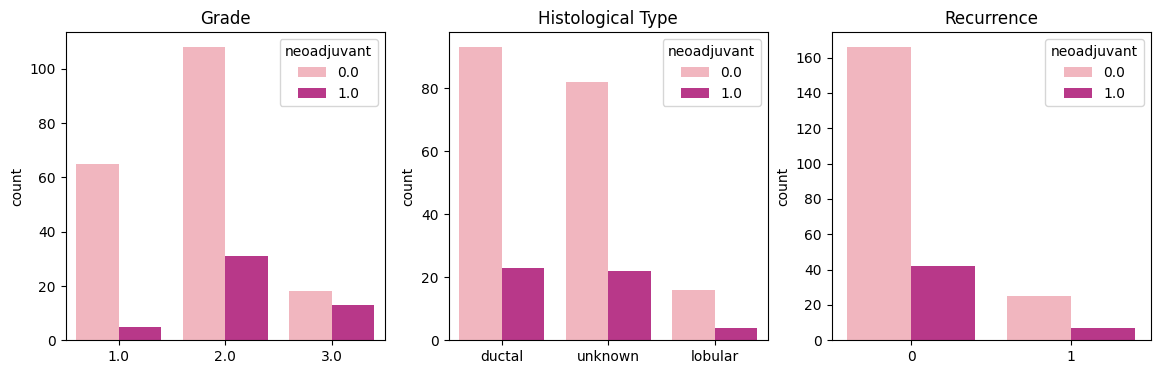

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.countplot(ax=axes[0], data=imputed_data, x="grade", hue="neoadjuvant", palette="RdPu")
axes[0].set(xlabel=None)
axes[0].set_title('Grade')

sns.countplot(ax=axes[1], data=imputed_data, x="hist_type", hue="neoadjuvant", palette="RdPu")
axes[1].set(xlabel=None)
axes[1].set_title('Histological Type')

sns.countplot(ax=axes[2], data=imputed_data, x="recurrence", hue="neoadjuvant", palette="RdPu")
axes[2].set(xlabel=None)
axes[2].set_title('Recurrence')

Text(0.5, 1.0, 'Distribution of years_from_diagnosis')

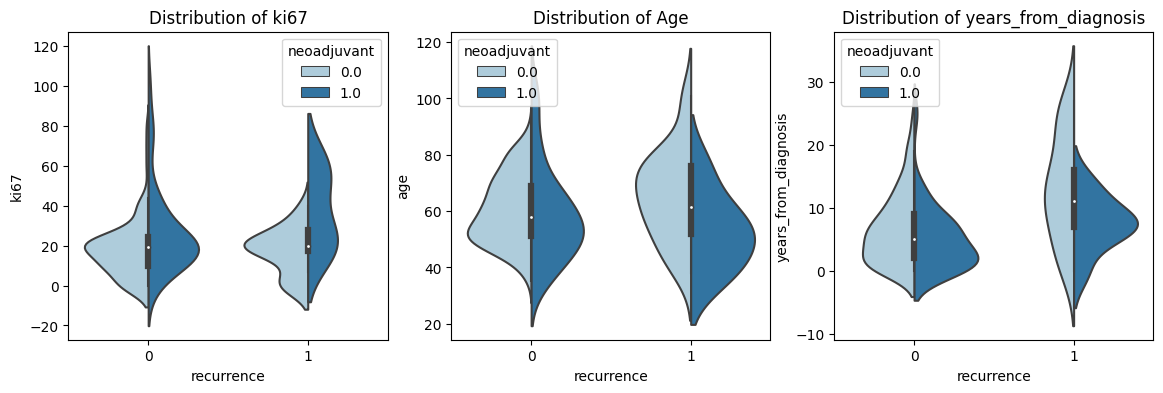

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.violinplot(ax=axes[0], data=imputed_data, x="recurrence", y="ki67", hue="neoadjuvant", split=True, palette="Paired")
axes[0].set_title('Distribution of ki67')

sns.violinplot(ax=axes[1], data=imputed_data, x="recurrence", y="age", hue="neoadjuvant", split=True, palette="Paired")
axes[1].set_title('Distribution of Age')

sns.violinplot(ax=axes[2], data=imputed_data, x="recurrence", y="years_from_diagnosis", hue="neoadjuvant", split=True, palette="Paired")
axes[2].set_title('Distribution of years_from_diagnosis')

### Map values and replace with most frequent

In [36]:
imputed_data.to_parquet(STAGE_DIR / 'patient-preprocessed-v3.parquet')